## Final Project: W207: Predicting Forest Cover Type: Sahab and Happiness Summer 2015

Use cartographic variables to classify forest categories.predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type. 

First Kaggle Submission: Knn

<img src="Leader Board Jul 18 at 8 perc.png">


Final Kaggle Submission: After Extra Trees Forest Classifier

<img src="Leader Board Aug 18 at 73 perc.jpg">

### SK-LEARN LIBRARIES

In [7]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import pandas as pd

# utility
from sklearn.pipeline import Pipeline

# preprocessing 
from sklearn.decomposition import PCA
from sklearn import preprocessing

# modelling 
from numpy.linalg import inv
from sklearn import svm, tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from matplotlib.colors import LogNorm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
# from sklearn import metrics


###INPUT DATA

In [22]:
#load csv imports

feature_names = np.loadtxt(hdr, dtype= str, delimiter = ',')

trf = open("train.csv")
trf.readline()  # skip the header
labelled_data_and_labels = np.loadtxt(trf, delimiter = ',')

tef = open("test.csv")
tef.readline()  # skip the header
test_data_raw = np.loadtxt(tef, delimiter = ',')

target_names = np.array(['1 - Spruce/Fir', '2 - Lodgepole Pine', '3 - Ponderosa Pine', '4 - Cottonwood/Willow', 
                         '5 - Aspen', '6 - Douglas-fir', '7 - Krummholz'])



####Feature names

 Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,
 Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,
 Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,
 Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,
 Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,
 Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,
 Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,
 Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,
 Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
 
 


###DESIGNATING DATA ROLES

Shuffle the data, but make sure that the features and accompanying labels stay in sync. Shuffling helps further randomize the data before splitting, in case the order of the data isnt independent of the
labels. We also made sur enot to inlude dummy variable ID in the analysis and modelling. 

In [9]:
# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
modelling_data_and_labels = labelled_data_and_labels 
np.random.seed(0)
shuffle = np.random.permutation(np.arange(modelling_data_and_labels.shape[0]))
modelling_data_and_labels = modelling_data_and_labels[shuffle]

# Get rid of ID, a dummy variable, in first column
modelling_data, modelling_labels = modelling_data_and_labels[:, 1:55], modelling_data_and_labels[:, -1]
test_data = test_data_raw[:,1:]
test_feature_names =  feature_names[1:55]

# Split into train and dev.
train_data, train_labels = modelling_data[:10000], modelling_labels[:10000]
dev_data,     dev_labels = modelling_data[10000:], modelling_labels[10000:]

print train_data.shape, ' ', train_labels.shape
print dev_data.shape, ' ',  dev_labels.shape
print test_data.shape, ' ', test_data.shape, 
# print test_feature_names


(10000L, 54L)   (10000L,)
(5120L, 54L)   (5120L,)
(565892L, 54L)   (565892L, 54L)


###Exploring Data


#### Lets Look at the data

Explore the sparsificity of the data, as well the magnitudes of the different features for each label

In [10]:
#pretty formatting for the data

np.set_printoptions(precision = 3, suppress=1)

# across all data
print 'All labels'
print "features " , train_data.mean(0) # average each column for all 55 features

# for reach label
for index in range(7):
        print "Label %s " %target_names[index]
        # print "features %s " %train_data[train_labels==index + 1]   
        mat_features = np.matrix(train_data[train_labels==index + 1])
        print "features " , mat_features.mean(0) # average each column for all 55 features

##Most of the features are zero
## sparse sets

All labels
features  [ 2749.771   157.239    16.551   227.482    51.242  1721.424   212.317
   218.936   135.508  1509.538     0.235     0.03      0.426     0.308
     0.026     0.04      0.063     0.056     0.01      0.042     0.        0.
     0.001     0.142     0.028     0.015     0.031     0.011     0.
     0.007     0.04      0.004     0.003     0.01      0.001     0.023
     0.049     0.017     0.        0.004     0.001     0.001     0.083
     0.047     0.023     0.046     0.04      0.001     0.006     0.001
     0.003     0.049     0.044     0.031]
Label 1 - Spruce/Fir 
features  [[ 3130.36    158.84     13.069   276.392    42.292  2612.911   211.22
    223.358   144.77   1958.166     0.483     0.08      0.437     0.        0.
      0.        0.        0.001     0.        0.        0.        0.
      0.001     0.004     0.004     0.011     0.007     0.        0.
      0.004     0.001     0.        0.008     0.022     0.005     0.129
      0.176     0.057     0.        0.004   

Dimension Reduction should help, given how sparse the features are

#### Fit basic models

Define scoring function feauturing a confusion matrix to see if there is any diffferential accuracy between the labels

In [11]:
def printCMatrix(result):
    confusionMatrix = confusion_matrix(dev_labels, result)
    plt.figure(1, figsize=(4, 4))
    plt.imshow(confusionMatrix, cmap=plt.cm.binary, interpolation = 'nearest')
    plt.colorbar()
    plt.xlabel('true value')
    plt.ylabel('predicted value')    

    print confusionMatrix

Run a baseline model: Start with kNN classifier, iterating to get best parameters

In [7]:
#Baseline

k_values = [1, 2, 3, 4, 5, 6, 7, 8 , 9, 10]
for k in k_values:
    # get the Classifier algorithm instance
    clf = KNeighborsClassifier(n_neighbors=k)
    #fit the data
    clf.fit(train_data, train_labels)
    #get the score
    accuracy = clf.score(dev_data, dev_labels)
    #print the accuracy

    print("Mean accuracy on dev set for k = %s: %s" % (k, accuracy))


Mean accuracy on dev set for k = 1: 0.8318359375
Mean accuracy on dev set for k = 2: 0.8015625
Mean accuracy on dev set for k = 3: 0.8080078125
Mean accuracy on dev set for k = 4: 0.79609375
Mean accuracy on dev set for k = 5: 0.78828125
Mean accuracy on dev set for k = 6: 0.78046875
Mean accuracy on dev set for k = 7: 0.7771484375
Mean accuracy on dev set for k = 8: 0.773046875
Mean accuracy on dev set for k = 9: 0.7626953125
Mean accuracy on dev set for k = 10: 0.7595703125


Explore kNN-1 farther

[[505 146   0   0  26   3  67]
 [146 466  23   1  66  26  10]
 [  0  18 552  45  10  87   0]
 [  0   0  17 718   0  24   0]
 [  6  22   4   0 711   3   0]
 [  2   4  58  23  10 608   0]
 [  9   5   0   0   0   0 699]]


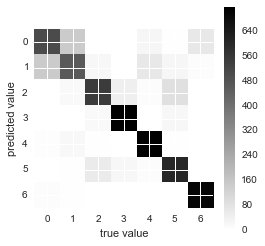

In [8]:
#Fit a 1-NN and output a confusion matrix for the dev data
# get the Classifier algorithm instance
neigh = KNeighborsClassifier(n_neighbors=1)
#fit the data
neigh.fit(train_data, train_labels)
result = neigh.predict(dev_data)
printCMatrix(result)    
#sprucefir and lodgepine are the ones most confused for each other
#2 and 3 have similar problem but on smaller scale
#0 and 1 are also confused by the rest

#should look more into that

Define function to iterate through models

In [12]:
def check_model(model, print_confusion_matrix):
    model.fit(train_data, train_labels)
    score = model.score(dev_data, dev_labels)
    print 'score:', score,'\n'
    result = model.predict(dev_data)
    if print_confusion_matrix==1:
        printCMatrix(result) 
        #print model.feature_importances_

Iterate through different basic models under typical settings and see relative perfomance

In [9]:
print "LinearRegression"
check_model(LinearRegression(), print_confusion_matrix=0)
print "LogisticRegression"
check_model(LogisticRegression(), print_confusion_matrix=0)
print "DecisionTree"
check_model(LogisticRegression(), print_confusion_matrix=0)
print "BernoulliNB(alpha=.0001)"
check_model(BernoulliNB( alpha=.0001), print_confusion_matrix=0)
print "GaussianNB"
check_model(GaussianNB(), print_confusion_matrix=0)
print 'DecisionTreeClassifier()'
check_model(tree.DecisionTreeClassifier(), print_confusion_matrix=0)
print 'RandomForestClassifier()'
check_model(RandomForestClassifier() , print_confusion_matrix=0)
#84.2 2 & 3 are less but 2 & 5ae more likely swapped
#break three subset label 1 &2, 4& 6, 3, 5, 7
#printCMatrix(result)
print 'ExtraTreesClassifier()'
check_model(ExtraTreesClassifier(n_estimators=1000, max_depth=None,
                                                    max_features=7,
                                                    min_samples_split=2, random_state=0,
                                                    bootstrap=False), print_confusion_matrix=0)
print 'AdaBoostClassifier()'
check_model(AdaBoostClassifier(), print_confusion_matrix=0)
print 'SVM()'
check_model(svm.SVC(), print_confusion_matrix=0)


LinearRegression
score: 0.394420990739 

LogisticRegression
score: 0.67421875 

DecisionTree
score: 0.6796875 

BernoulliNB(alpha=.0001)
score: 0.608984375 

GaussianNB
score: 0.477734375 

DecisionTreeClassifier()
score: 0.7947265625 

RandomForestClassifier()
score: 0.828515625 

ExtraTreesClassifier()
score: 0.858984375 

AdaBoostClassifier()
score: 0.4853515625 

SVM()
score: 0.13828125 



Choose top 3 models:  Decision Tree, Random Forest, Extra-trees

DecisionTreeClassifier()
score: 0.794140625 

[[499 176   0   0  17   2  53]
 [155 473  14   0  64  17  15]
 [  3  15 503  37  13 141   0]
 [  0   0  40 695   0  24   0]
 [ 18  36   9   0 678   5   0]
 [  5   9  93  24  10 564   0]
 [ 46  13   0   0   0   0 654]]


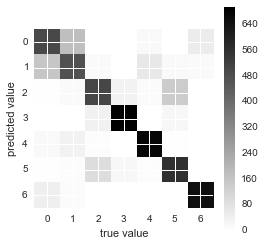

In [10]:
print 'DecisionTreeClassifier()'
check_model(tree.DecisionTreeClassifier(),print_confusion_matrix=1)


Horizontal_Distance_To_Roadways is the most imp, and elevation is the second most imp. 3 of them are zeros.
21, 22, 29 are not important
'Soil_Type6' 'Soil_Type7', and soil type 14 are not imp

'Soil_Type6' 'Soil_Type7', and soil type 14 are not imp

RandomForestClassifier()
score: 0.828515625 

[[559 113   1   0  19   3  52]
 [172 469  23   1  51  15   7]
 [  0  10 551  35   9 107   0]
 [  0   0  23 727   0   9   0]
 [  7  28  10   0 692   9   0]
 [  0   8  95  24   4 574   0]
 [ 36   5   0   0   2   0 670]]


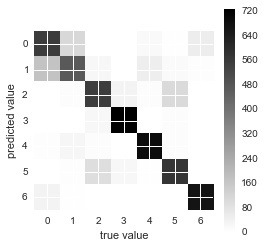

In [11]:
print 'RandomForestClassifier()'
check_model(RandomForestClassifier() , print_confusion_matrix=1)
#84.2 2 & 3 are less but 2 & 5ae more likely swapped
#break three subset label 1 &2, 4& 6, 3, 5, 7

ExtraTreesClassifier()
score: 0.830859375 

[[551 134   0   0  19   2  41]
 [155 493  17   0  51  18   4]
 [  0   7 560  36  10  99   0]
 [  0   0  23 725   0  11   0]
 [  9  42   7   0 679   9   0]
 [  0   8  97  23   7 570   0]
 [ 30   7   0   0   0   0 676]]


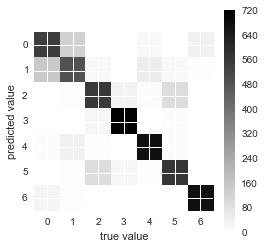

In [12]:
print 'ExtraTreesClassifier()'
check_model(ExtraTreesClassifier(),print_confusion_matrix=1)

### PREPROCESSING & FEATURE ENGINEERING

#### Dimension Reduction through PCA 

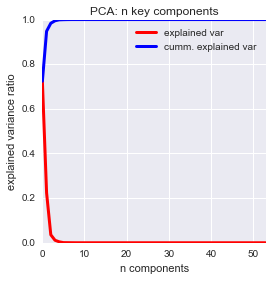

[ 0.724  0.948  0.983  0.995  0.999  0.999  1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.   ]

Choose 7 components: 99.98 % of all variance.



In [13]:
pca = PCA()
pca.fit_transform(train_data)

pca_explnd_variance = pca.explained_variance_ratio_

plt.figure(1, figsize=(4, 4))
plt.clf()
plt.plot(pca_explnd_variance,  linewidth=3, c='r', label='explained var')
plt.plot(np.cumsum(pca_explnd_variance),  linewidth=3, c='b', label='cumm. explained var')
plt.axis('tight')
plt.xlabel('n components')
plt.ylabel('explained variance ratio')
plt.legend()
plt.title('PCA: n key components')
plt.show()

print np.cumsum(pca_explnd_variance);
print '\nChoose 7 components:' ,  np.round(100*np.sum(pca_explnd_variance[0:7]), 3) , '% of all variance.\n' 

pca1 = PCA(n_components=7).fit(train_data)
reduced_train_data = pca1.transform(train_data)
reduced_test_data = pca1.transform(test_data)
reduced_dev_data = pca1.transform(dev_data)


####Scale and Impute

Imputing compensates for missing data, while scaling to normal makes outliers less voluble

In [14]:
#imputing i.e. substituting for missing values

imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imputed_train_data = imp.fit_transform(reduced_train_data) 
imputed_test_data = imp.fit_transform(reduced_test_data) 
imputed_dev_data = imp.fit_transform(reduced_dev_data)

# SCALE to normal
# scaled_train_data = preprocessing.scale(train_data) #, OR 
scaler = preprocessing.StandardScaler().fit(imputed_train_data)
scaled_train_data = scaler.transform(imputed_train_data) 
scaled_test_data = scaler.transform(imputed_test_data) 
scaled_dev_data = scaler.transform(imputed_dev_data) 

Define function to iterate chosen models on pre-processed data

In [15]:
def check_model2(model, print_confusion_matrix):
    model.fit(scaled_train_data, train_labels)
    score = model.score(scaled_dev_data, dev_labels)
    print  'score:', score
    result = model.predict(scaled_dev_data)
    if print_confusion_matrix==1:
        printCMatrix(result) 
        #print model.feature_importances_

Score Random Forest and Extra-trees Classifier on scaled data

RandomForestClassifier()
score: 0.7931640625
[[535 127   0   0  16   2  67]
 [169 431  31   0  58  30  19]
 [  0  24 519  38   6 125   0]
 [  0   0  27 712   0  20   0]
 [  9  51  12   0 664  10   0]
 [  1  11 109  31  12 541   0]
 [ 51   3   0   0   0   0 659]]


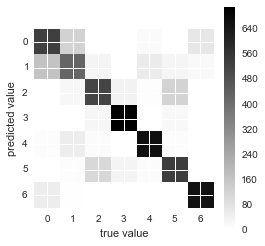

In [16]:
print 'RandomForestClassifier()'
check_model2(RandomForestClassifier(),print_confusion_matrix=1)

ExtraTreesClassifier()
score: 0.8541015625
[[568 111   0   0  21   1  46]
 [142 478  25   0  56  29   8]
 [  0  16 563  27   8  98   0]
 [  0   0  12 739   0   8   0]
 [  2  22   4   0 711   7   0]
 [  0   3  54  15   6 627   0]
 [ 26   0   0   0   0   0 687]]


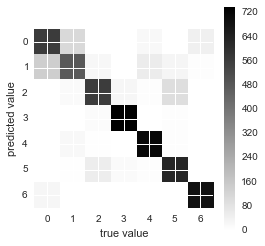

In [17]:
print 'ExtraTreesClassifier()'
check_model2(ExtraTreesClassifier(n_estimators=1000, max_depth=None,
                                                    max_features=7,
                                                    min_samples_split=2, random_state=0,
                                                    bootstrap=False),print_confusion_matrix=1)

####Explore Binarizing Features

In [18]:
binarizer = preprocessing.Binarizer()
binarized_train_data = binarizer.fit_transform(scaled_train_data) 
binarized_test_data = binarizer.fit_transform(scaled_test_data) 
binarized_dev_data = binarizer.fit_transform(scaled_dev_data)

Define checking function for binarized data

In [19]:
def check_model3(model, print_confusion_matrix):
    model.fit(binarized_train_data, train_labels)
    score = model.score(binarized_dev_data, dev_labels)
    print  'score:', score
    result = model.predict(binarized_dev_data)
    if print_confusion_matrix==1:
        printCMatrix(result) 

Test leading models after binarization

In [20]:
print 'RandomForestClassifier()'
check_model3(RandomForestClassifier(),print_confusion_matrix=0)
print 'ExtraTreesClassifier()'
check_model3(ExtraTreesClassifier(n_estimators=1000, max_depth=None,
                                                    max_features=7,
                                                    min_samples_split=2, random_state=0,
                                                    bootstrap=False),print_confusion_matrix=0)

RandomForestClassifier()
score: 0.4435546875
ExtraTreesClassifier()
score: 0.4392578125


Binarization worsens performance.  Do not binarize. 

###Optimize model parameters: Extra Trees Classifier

Do a grid search over the main parameters of the classifer, and pick the best performing parameters

In [21]:
# TAKES 2HRS TO RUN BECAUSE OF THE SIZE OF THE DATA
model = ExtraTreesClassifier(verbose=0, bootstrap=False)
#parameters = { 'n_estimators': np.arange(100,600,100), 'max_features': ('auto', ) }

parameters = {'n_estimators' :np.arange(100,1000,100),'criterion' :('gini', 'entropy'),
             'max_features' :('auto','sqrt', 'log2',),'n_jobs' :np.arange(10, 100, 10),
             'class_weight':('auto','subsample', )}

gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(scaled_train_data, train_labels)
print "Best parameters:"
print gs.best_params_

score = gs.score(scaled_dev_data, dev_labels)
predictions = gs.predict(scaled_dev_data)
print "Accuracy: %s" % (score)
# print(classification_report(dev_labels, predictions))
# print confusion_matrix(dev_labels, predictions)

Best parameters:
{'max_features': 'sqrt', 'n_estimators': 900, 'n_jobs': 10, 'criterion': 'entropy', 'class_weight': 'auto'}
Accuracy: 0.848828125


C:\Users\Happiness\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\grid_search.py:370: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


####Our optimized Extra Trees Classifier, and applying the same parameters to the Random Forest Classifier ( 2nd performing model)

In [16]:
final_model_ETC = ExtraTreesClassifier(n_estimators=900, 
                                  max_features= 'auto',
                                  n_jobs= 10, 
                                  criterion= 'entropy', 
                                  class_weight='auto',
                                  bootstrap=False)
print 'ExtraTreesClassifier()'
check_model2(final_model_ETC, print_confusion_matrix=1)

ExtraTreesClassifier()


RandomForestClassifier()
score: 0.84296875
[[547 124   0   0  15   1  60]
 [139 477  29   0  52  29  12]
 [  0  15 557  30   8 102   0]
 [  0   0  14 737   0   8   0]
 [  5  21   6   0 703  11   0]
 [  0   4  62  22   7 610   0]
 [ 27   1   0   0   0   0 685]]


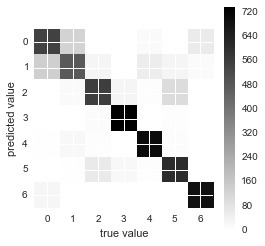

In [10]:
final_model_RFC = RandomForestClassifier(n_estimators=900, 
                                  max_features= 'auto',
                                  n_jobs= 10, 
                                  criterion= 'entropy', 
                                  class_weight='auto',
                                  bootstrap=False)
print 'RandomForestClassifier()'
check_model2(final_model_RFC, print_confusion_matrix=1)

###FINAL MODEL & OUTPUT 


For the final model, train on entire labelled data-set

In [17]:
#CHOSEN CLASSIFICATION MODEL

# Fit entire labelled dataset
# recombine engineered train and dev feature data
scaled_modelling_data = np.vstack((scaled_train_data, scaled_dev_data))
print train_labels.reshape(-1,1).shape, dev_labels.reshape(-1,1).shape

#also recombine labels
modelling_labels = np.vstack((train_labels.reshape(-1,1), dev_labels.reshape(-1,1))).ravel()
print scaled_modelling_data.shape
print modelling_labels.shape

(10000L, 1L) (5120L, 1L)
(15120L, 7L)
(15120L,)


Fit final model to all labelled training data

In [18]:
# Extra Trees Classifier
model=final_model_ETC
model_fit = model.fit(scaled_modelling_data, modelling_labels) # all data

In [25]:
pred_test_lbls = model_fit.predict(scaled_test_data)

####GENERATE OUTPUT FILE FOR KAGGLE SUBMISSION

In [28]:
# recover the IDS which are important for data submission but not for modelling
test_ids = test_data_raw[:,0]

# format the numeric parts of the output file under prescribed formats
output = np.array([test_ids, pred_test_lbls])
output = output.T
output.astype(int)

# convert to dataframe and use Pandas export to_csv utility
output_df = pd.DataFrame(output, columns=('Id', 'Cover_Type'))
output_df.to_csv("test_out_ii.csv", index=False, cols=['Id', 'Cover_Type'])

##APPENDIX

Exploring extra features, beyond key 7 components

0.8681640625
[[577 115   0   0  19   1  35]
 [121 524  15   1  48  23   6]
 [  0   7 584  33   9  79   0]
 [  0   0  14 733   0  12   0]
 [  3  16   5   0 715   7   0]
 [  0   1  53  24   5 622   0]
 [ 22   1   0   0   0   0 690]]
[ 0.121  0.058  0.145  0.058  0.042  0.035  0.027  0.038  0.029  0.023
  0.077  0.133  0.062  0.067  0.084]


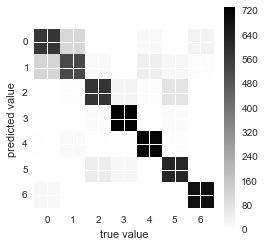

In [18]:
pca1 = PCA(n_components=15).fit(train_data)
reduced_train_data = pca1.transform(train_data)
reduced_test_data = pca1.transform(test_data)
reduced_dev_data = pca1.transform(dev_data)
model = ExtraTreesClassifier(n_estimators=1000, max_depth=None, 
                                                    max_features=7,
                                                    min_samples_split=2, random_state=0,
                                                    bootstrap=False)
model.fit(reduced_train_data, train_labels)
score = model.score(reduced_dev_data, dev_labels)
print score
result = model.predict(reduced_dev_data)
printCMatrix(result) 
print model.feature_importances_

Explore Seperating 1 and 2, maybe 6 and 3 too

In [10]:
# FUTURE WORK: UNFINISHED
type1and2_labels = np.where(np.logical_or(train_labels==1 , train_labels==2))
#type1and2_data = reduced_train_data[type1and2_labels]
type1and2_data = train_data[type1and2_labels]
type3and6_labels = np.where(np.logical_or(train_labels==3, train_labels==6))
#type3and6_data = reduced_train_data[type3and6_labels]
type3and6_data = train_data[type3and6_labels]
typeothers_labels = np.where(np.logical_or(train_labels==4 , train_labels==7, train_labels ==5))
#typeothers_data = reduced_train_data[typeothers_labels]  
typeothers_data = train_data[typeothers_labels]
pca1 = PCA(n_components=15).fit(type1and2_data)
reduced_train_data2 = pca1.transform(type1and2_data)
print reduced_train_data2.shape
pca2 = PCA(n_components=15).fit(type3and6_data)
reduced_train_data3 = np.vstack((pca2.transform(type3and6_data), reduced_train_data2))
reduced_train_data3.shape
pca3 = PCA(n_components=15).fit(typeothers_data)
reduced_train_data4 = np.vstack((pca3.transform(typeothers_data), reduced_train_data3))

reduced_test_data = pca1.transform(test_data)
reduced_dev_data = pca1.transform(dev_data)
labels = np.append(type1and2_labels,type3and6_labels )
labels = np.append(typeothers_labels, labels)
print labels.shape
#print type1and2_data.shape
print reduced_train_data4.shape
print train_labels.shape
#print type3and6_data.shape
#print typeothers_data.shape

#clf1.fit(type1and2_data, np.ravel(type1and2_labels))

#clf2 = ExtraTreesClassifier()
#clf2.fit(type3and6_data, np.ravel(type3and6_labels))

#clf3 = ExtraTreesClassifier()
#clf3.fit(typeothers_data , np.ravel(typeothers_labels))

model = ExtraTreesClassifier(n_estimators=1000, max_depth=None, 
                                                    max_features=7,
                                                    min_samples_split=2, random_state=0,
                                                    bootstrap=False)
model.fit(reduced_train_data4, labels)
score = model.score(reduced_dev_data, dev_labels)
print score
result = model.predict(reduced_dev_data)
printCMatrix(result) 
print model.feature_importances_


(2835L, 15L)
(8586L,)
(8586L, 15L)
(10000L,)
